# Notebook settings
This notebook is a universal frame for training the DistilBERT+Linearmodel. It can take in any Parquet dataset with suitable configuration.

**This version is for datasets with separate Parquets for training, validation and test sets.**

In [1]:
### Dataset configuration
# The main folder. It should be located inside datasets/. Inside it should be three .parquet folders or files.
DATASET_NAME   = 'DBPedia'
# The input text column
TEXT_COL_NAME  = 'text'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 3

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

Using cuda


# Import data

In [3]:
data = dd.read_parquet('../../datasets/{}/train.parquet'.format(DATASET_NAME))
data_val = dd.read_parquet('../../datasets/{}/val.parquet'.format(DATASET_NAME))
data_test = dd.read_parquet('../../datasets/{}/val.parquet'.format(DATASET_NAME))
data.head(10)

,text,category
0,"William Alexander Massey (October 7, 1856 – Ma...","[Agent, Politician, Senator]"
1,Lions is the sixth studio album by American ro...,"[Work, MusicalWork, Album]"
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...","[Place, NaturalPlace, Mountain]"
3,Cancer Prevention Research is a biweekly peer-...,"[Work, PeriodicalLiterature, AcademicJournal]"
4,The Princeton University Chapel is located on ...,"[Place, Building, HistoricBuilding]"
5,Sistrurus catenatus edwardsii is a subspecies ...,"[Species, Animal, Reptile]"
6,"The 1st Battalion, 68th Armor Regiment (1–68 A...","[Agent, Organisation, MilitaryUnit]"
7,John Warren Davis (commonly known as J. Warren...,"[Agent, Person, Judge]"
8,"Alfrēds Hartmanis (November 1, 1881, Riga, Lat...","[Agent, Athlete, ChessPlayer]"
9,The International Association of Plumbing and ...,"[Agent, Organisation, TradeUnion]"


# Categorical-encode the classes
DistilBERT+Linear only classifiers the leaf level. No hierarchy yet. Also, we'll be using a linear layer in PyTorch, which necessitates us to encode these classes manually.

The reason we're not using one-hot encoding is because we're about to use PyTorch's cross-entropy loss implementation, which only needs indices.

For categorical encoding to work, the column itself must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

In [4]:
def encode_categories(df):
    df['targets'] = df[CLASS_COL_NAME].apply(
        lambda lst: lst[min(DEPTH-1, len(lst)-1)], meta=(CLASS_COL_NAME, 'object')
    ).astype('category').cat.as_known()

    df['codes'] = df['targets'].cat.codes
    
encode_categories(data)
encode_categories(data_val)
encode_categories(data_test)

Keep a mapping between category code and category names (in strings) so we can get human-readable predictions later. We'll only do the scanning step over the training set, that is, we'll assume that the training set is decent enough to include at least one example for every class.

In [5]:
def create_bidirectional_mappings(df):
    cls2idx = dict([
        (cls, index) 
        for (index, cls) 
        in enumerate(data['targets'].cat.categories)
    ])
    idx2cls = list(data['targets'].cat.categories)
    return cls2idx, idx2cls

cls2idx, idx2cls = create_bidirectional_mappings(data)

print('Class-index mapping:', cls2idx)
print('Index-class mapping:', idx2cls)

Class-index mapping: {'AcademicJournal': 0, 'AdultActor': 1, 'Airline': 2, 'Airport': 3, 'Album': 4, 'AmateurBoxer': 5, 'Ambassador': 6, 'AmericanFootballPlayer': 7, 'Amphibian': 8, 'AnimangaCharacter': 9, 'Anime': 10, 'Arachnid': 11, 'Architect': 12, 'ArtificialSatellite': 13, 'ArtistDiscography': 14, 'Astronaut': 15, 'AustralianFootballTeam': 16, 'AustralianRulesFootballPlayer': 17, 'AutomobileEngine': 18, 'BadmintonPlayer': 19, 'Band': 20, 'Bank': 21, 'Baronet': 22, 'BaseballLeague': 23, 'BaseballPlayer': 24, 'BaseballSeason': 25, 'BasketballLeague': 26, 'BasketballPlayer': 27, 'BasketballTeam': 28, 'BeachVolleyballPlayer': 29, 'BeautyQueen': 30, 'BiologicalDatabase': 31, 'Bird': 32, 'Bodybuilder': 33, 'Brewery': 34, 'Bridge': 35, 'BroadcastNetwork': 36, 'BusCompany': 37, 'BusinessPerson': 38, 'CanadianFootballTeam': 39, 'Canal': 40, 'Canoeist': 41, 'Cardinal': 42, 'Castle': 43, 'Cave': 44, 'Chef': 45, 'ChessPlayer': 46, 'ChristianBishop': 47, 'ClassicalMusicArtist': 48, 'ClassicalM

Also keep the number of leaves for later model construction.

In [6]:
leaf_count = len(cls2idx)

Now we can generate our custom-ordered, global binary encoding.

$|Y_L^h|$ can easily be sliced from the global encoding by relying on the backed-up per-level class counts.

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [7]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Checkpoints

In [8]:
def load_checkpoint(checkpoint_fpath, model, optimizer=None):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface. This version of the notebook uses an out-of-core implementation based on PyTorch's `IterableDataset`.

In [9]:
from torch.utils.data import IterableDataset
class CustomDataset(IterableDataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.iterator = df.itertuples()
        self.max_len = max_len
        
    def __next__(self):
        row = next(self.iterator)
        text = str(getattr(row, TEXT_COL_NAME))
        text = " ".join(text.split())
        inputs = self.tokenizer(
            text,
            None, # No text_pair
            add_special_tokens=True, # CLS, SEP
            max_length=self.max_len, # For us it's a hyperparam. See next cells.
            padding='max_length',
            truncation=True
            # BERT tokenisers return attention masks by default
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(getattr(row, 'codes'), dtype=torch.float)
        }
        
    def __iter__(self):
        return self

Regarding that `max_len` hyperparameter, let's see the text lengths' distribution:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

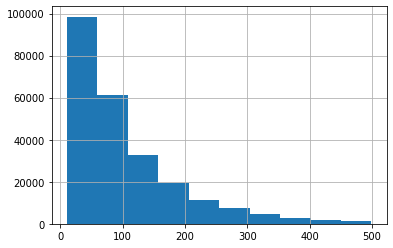

In [10]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings.

In [11]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

config = {
    'lr': 1e-05,
    'epochs': 5,
    'dropout': 0.25,
}

### Don't change these if you need to compare with published results
MAX_LEN = 64 # Amazon_Category sets should use 64, Walmart_30k uses 32 and DBPedia 256.
TRAIN_MINIBATCH_SIZE = 32
VAL_TEST_MINIBATCH_SIZE = 64

# Don't touch this part
train_minibatch_count = len(data) // TRAIN_MINIBATCH_SIZE
val_minibatch_count = len(data_val) // VAL_TEST_MINIBATCH_SIZE
test_minibatch_count = len(data_test) // VAL_TEST_MINIBATCH_SIZE

mkdir: cannot create directory ‘checkpoints-DBPedia’: File exists


## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by a dropout layer and a linear layer for leaf category classification.

In [12]:
import torch
from tqdm.notebook import tqdm
from functools import reduce

class DB_Linear(torch.nn.Module):

  def __init__(self, config, output_count):
    super(DB_Linear, self).__init__()
    self.l1 = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.l2 = torch.nn.Dropout(config['dropout'])
    self.l3 = torch.nn.Linear(768, output_count) # DistilBERT outputs 768 values.
    self.output_size = output_count

  def forward(self, ids, mask):
    output_1 = self.l1(ids, attention_mask = mask)[0][:,0,:]
    output_2 = self.l2(output_1)
    output = self.l3(output_2)
    return output

model = DB_Linear(config, leaf_count)

model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DB_Linear(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=76

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

For now we'll stick with one of the provided loss functions instead of building anything radical. As we are performing multiclass classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary).

We also construct our optimiser here.



# Training time

In [13]:
from sklearn import metrics
def get_metrics(output, targets):
    # Get predicted codes
    predicted_leaf_codes = np.argmax(output, axis=1)

    acc = metrics.accuracy_score(predicted_leaf_codes, targets)
    pre = metrics.precision_score(predicted_leaf_codes, targets, average='weighted', zero_division=0)
    print('Leaf level metrics:')
    print("Accuracy:", acc)
    print("Precision:", pre)
    
    return np.array([acc, pre])

In [14]:
from tqdm.notebook import tqdm

def train_model(config, data, data_val, model, checkpoint_path, best_checkpoint_path):

  # Store validation metrics after each epoch
  val_metrics = np.empty((2, 0), dtype=float)
    
  criterion = torch.nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

  val_loss_min = np.Inf
  for epoch in range(1, config['epochs'] + 1):
    # Reset iterable datasets and loaders to beginning
    train_set = CustomDataset(data, tokenizer, MAX_LEN)
    val_set = CustomDataset(data_val, tokenizer, MAX_LEN)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=TRAIN_MINIBATCH_SIZE)
    val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=VAL_TEST_MINIBATCH_SIZE)
    train_loss = 0
    val_loss = 0
    # Put model into training mode. Note that this call DOES NOT train it yet.
    model.train()
    print('Epoch {}: Training'.format(epoch))
    for batch_idx, batch in enumerate(tqdm(train_loader, total=train_minibatch_count)):
      ids = batch['ids'].to(device, dtype = torch.long)
      mask = batch['mask'].to(device, dtype = torch.long)
      targets = batch['labels'].to(device, dtype = torch.long)

      outputs = model(ids, mask)

      loss = criterion(outputs, targets)

      # PyTorch defaults to accumulating gradients, but we don't need that here
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

    print('Epoch {}: Validation'.format(epoch))
    
    
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    model.eval()

    val_targets = np.array([], dtype=float)
    val_outputs = np.empty((0, model.output_size), dtype=float)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
      total_loss = 0
      for batch_idx, batch in enumerate(tqdm(val_loader, total=val_minibatch_count)):
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)

        loss = criterion(outputs, targets)

        total_loss += loss

        val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)
        
        val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
        val_outputs = np.concatenate([val_outputs, outputs.cpu().detach().numpy()])

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      print('Average minibatch loss:', total_loss / val_minibatch_count)
    
      val_metrics = np.concatenate([val_metrics, 
                                    np.expand_dims(get_metrics(val_outputs, val_targets), axis=1)],
                                   axis=1)
      train_loss = train_loss/train_minibatch_count
      val_loss = val_loss/val_minibatch_count
      # Print training/validation statistics 
      print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
            train_loss,
            val_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
      
      best_yet = False
      if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        # save checkpoint as best model
        best_yet = True
        val_loss_min = val_loss
        
      save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
    print('Epoch {}: Done\n'.format(epoch))
  return model, val_metrics

# Alternative: just load from disk
def run_model(model, loader, minibatch_count=None):
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  model.eval()

  all_targets = np.array([], dtype=bool)
  all_outputs = np.empty((0, model.output_size), dtype=float)

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(loader, total=minibatch_count)):
      ids = batch['ids'].to(device, dtype = torch.long)
      mask = batch['mask'].to(device, dtype = torch.long)
      targets = batch['labels'].long()

      outputs = model(ids, mask)

      all_targets = np.concatenate([all_targets, targets.numpy()])
      all_outputs = np.concatenate([all_outputs, outputs.cpu().detach().numpy()])
  return {
      'targets': all_targets,
      'outputs': all_outputs,
  }

Epoch 1: Training


  0%|          | 0/7529 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/562 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.1891, device='cuda:0')
Leaf level metrics:
Accuracy: 0.9513929394772658
Precision: 0.9555479166449757
Avgerage training loss: 0.000080
Average validation loss: 0.000336
Validation loss decreased (inf --> 0.000336).  Saving model ...
Epoch 1: Done

Epoch 2: Training


  0%|          | 0/7529 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/562 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.1694, device='cuda:0')
Leaf level metrics:
Accuracy: 0.9542538121823182
Precision: 0.9580518181259865
Avgerage training loss: 0.000022
Average validation loss: 0.000301
Validation loss decreased (0.000336 --> 0.000301).  Saving model ...
Epoch 2: Done

Epoch 3: Training


  0%|          | 0/7529 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/562 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.1695, device='cuda:0')
Leaf level metrics:
Accuracy: 0.955559258950643
Precision: 0.9582906448477861
Avgerage training loss: 0.000016
Average validation loss: 0.000301
Epoch 3: Done

Epoch 4: Training


  0%|          | 0/7529 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/562 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.1780, device='cuda:0')
Leaf level metrics:
Accuracy: 0.955392606171708
Precision: 0.957538410576958
Avgerage training loss: 0.000012
Average validation loss: 0.000316
Epoch 4: Done

Epoch 5: Training


  0%|          | 0/7529 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/562 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.1798, device='cuda:0')
Leaf level metrics:
Accuracy: 0.9566702774768769
Precision: 0.9581870667408046
Avgerage training loss: 0.000009
Average validation loss: 0.000319
Epoch 5: Done



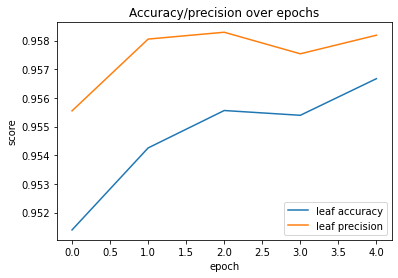

In [15]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        data,
        data_val,
        model,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, model)

In [16]:
test_set = CustomDataset(data_test, tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=VAL_TEST_MINIBATCH_SIZE)
test_result = run_model(trained_model, test_loader, test_minibatch_count)

  0%|          | 0/562 [00:00<?, ?it/s]

# Evaluation
We'll mainly use the leaf prediction in real-world applications to ensure 100% hierarchy matches. However, we'll still test with the global encoding just to see what we are getting.

## Transform results
First, transform the leaf predictions into names so we can have a human-readable view of what's going on.

In [17]:
target_codes = test_result['targets']
output_scores = test_result['outputs']
target_codes

array([169, 104, 157, ...,  89,  95, 209])

In [18]:
output_codes = np.argmax(output_scores, axis=1)
output_codes

array([169, 104, 157, ...,  89,  95, 209])

Let's convert that back to strings for human readability, just to make sure we're doing it right:

In [19]:
output_classes = [*map(lambda code: idx2cls[code], output_codes)]
output_classes

['RailwayStation',
 'Hospital',
 'PoliticalParty',
 'Architect',
 'HandballTeam',
 'BroadcastNetwork',
 'Mountain',
 'AutomobileEngine',
 'SoccerPlayer',
 'Planet',
 'ArtistDiscography',
 'Noble',
 'SoccerManager',
 'Gymnast',
 'ChessPlayer',
 'RailwayLine',
 'SpeedwayRider',
 'Airport',
 'River',
 'Magazine',
 'TableTennisPlayer',
 'Lake',
 'Road',
 'ChessPlayer',
 'Planet',
 'BasketballTeam',
 'RaceHorse',
 'Arachnid',
 'RugbyClub',
 'FashionDesigner',
 'Governor',
 'MilitaryConflict',
 'Bird',
 'Election',
 'BasketballLeague',
 'RugbyPlayer',
 'ShoppingMall',
 'Planet',
 'CultivatedVariety',
 'AmericanFootballPlayer',
 'Arachnid',
 'Museum',
 'Lake',
 'Publisher',
 'Swimmer',
 'Medician',
 'Mountain',
 'President',
 'Swimmer',
 'Reptile',
 'RailwayLine',
 'Cricketer',
 'Airline',
 'HockeyTeam',
 'ChristianBishop',
 'HockeyTeam',
 'River',
 'Castle',
 'Play',
 'RailwayLine',
 'EurovisionSongContestEntry',
 'ShoppingMall',
 'Convention',
 'RecordLabel',
 'Bank',
 'GolfPlayer',
 'Mollu

Visual match-up:

In [20]:
target_classes = [ idx2cls[code] for code in target_codes]
import pandas as pd
comp_df = pd.DataFrame({'Predicted': output_classes, 'Actual': target_classes})
comp_df

,Predicted,Actual
0,RailwayStation,RailwayStation
1,Hospital,Hospital
2,PoliticalParty,PoliticalParty
3,Architect,Architect
4,HandballTeam,HandballTeam
...,...,...
35998,Convention,Convention
35999,Magazine,Magazine
36000,GolfTournament,GolfTournament
36001,HandballPlayer,HandballPlayer


## Metrics

In [21]:
def generate_one_hot(idx):
    b = np.zeros(leaf_count, dtype=bool)
    b[idx] = 1
    return b

binarised_targets = np.array([generate_one_hot(code) for code in test_result['targets']])

print('Leaf level:')
print("Accuracy:", metrics.accuracy_score(output_codes, target_codes))
print("Precision:", metrics.precision_score(output_codes, target_codes, average='weighted'))

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'], np.ones((1, leaf_count))], axis=0)

rectified_targets = np.concatenate([binarised_targets, np.ones((1, leaf_count), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

Leaf level:
Accuracy: 0.9566702774768769
Precision: 0.9581870667408046


Rectified leaf-level AU(PRC) score: 0.9616754382646491
